In [3]:
import sys,os,os.path
os.environ['PATH']=os.environ['PATH']+':/rzhome/ammannma/texlive/2019/bin/x86_64-linux'

#mpl.use("pgf")

path = "../../workspace/figures"

%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [4]:
%set_env TF_FORCE_GPU_ALLOW_GROWTH=true

import numpy as np
import tensorflow as tf

import librosa

import librosa.display

from grog.audioreader import AudioReader
from grog.models.model import Model
from grog.models.infer import Inference
from grog.config import Config
from grog.util import pad_or_truncate

from mpl_toolkits.mplot3d import Axes3D

import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import itertools

%set_env TF_FORCE_GPU_ALLOW_GROWTH=true

env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: TF_FORCE_GPU_ALLOW_GROWTH=true


In [5]:
plt.rcParams.update({
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
    "pgf.texsystem": "pdflatex",
    "lines.linewidth": 0.5,
#    'figure.dpi': 300,
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
         ]
})

In [6]:
FONT_SIZE=8

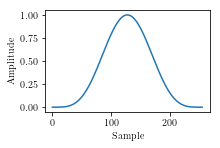

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure(figsize=(3, 2))

plt.plot(np.hanning(256) ** 2)
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.tight_layout(.5)
plt.show()

plt.savefig(os.path.join(path, "hann.pdf"))
#plt.savefig(os.path.join(path, "hann.pgf"))

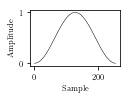

In [51]:
plt.figure(figsize=(2.0, 1.5))

plt.plot(scipy.signal.hann(256, sym=False), color='black')
plt.ylabel("Amplitude", fontsize = FONT_SIZE)
plt.xlabel("Sample", fontsize = FONT_SIZE)
plt.xticks(fontsize = FONT_SIZE)
plt.yticks(fontsize = FONT_SIZE)
plt.tight_layout()
plt.savefig(os.path.join(path, "hann.pdf"), bbox_inches = 'tight',pad_inches = 0)

plt.show()


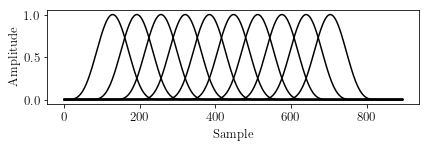

In [63]:
window = scipy.signal.hann(256, sym=False) ** 2

plt.figure(figsize=(6,2))
for i in range(10):
    plt.plot(np.pad(window, (i*64,(10-i) * 64), mode='edge'), color='black')
plt.ylabel("Amplitude", fontsize = FONT_SIZE)
plt.xlabel("Sample", fontsize = FONT_SIZE)
plt.xticks(fontsize = FONT_SIZE)
plt.yticks(fontsize = FONT_SIZE)
plt.tight_layout(.5)

plt.savefig(os.path.join(path, "hann_overlapping.pdf"))

9600.0


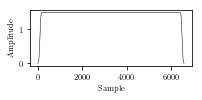

In [52]:
window = scipy.signal.hann(256, sym=False)

wss = librosa.filters.window_sumsquare(window, 100, win_length=256, n_fft=256, hop_length=64)
print(np.sum(wss))
fig, ax1 = plt.subplots(figsize=(3,1.5))

ax1.plot(wss, color='black')
#ax1.axvline(x=192)
#ax1.axvline(x=99*64+128)

#ax1.set_xlim(0, len(wss))
ax1.set_ylabel("Amplitude", fontsize = FONT_SIZE)
ax1.set_xlabel("Sample", fontsize = FONT_SIZE)
ax1.tick_params(axis="x", labelsize=FONT_SIZE)
ax1.tick_params(axis="y", labelsize=FONT_SIZE)

fig.tight_layout()

fig.savefig(os.path.join(path, "window_sumsquare.pdf"), bbox_inches = 'tight',pad_inches = 0)
fig.show()

## Spectogram visualisation

In [151]:
mix_path = "../../workspace/eval/wsj0-train-mix.wav"
model_dir = "../../workspace/exp-models/1a/seeds"
config = Config()
config.load_json("../../sync/experiments/1a/config.json")

inference = Inference(config)
mix, _ = librosa.load(mix_path, sr=8000)
mix_spec = librosa.core.stft(mix, n_fft=256, hop_length=64, window=np.hanning, center=False)

session, embedding_model, in_data, in_data, dropout_ff, dropout_rc = inference.prepare_session(model_dir)
embeddings, N_samples = inference.estimate_embeddings(session, mix, embedding_model, in_data, dropout_ff, dropout_rc)
session.close()

In [154]:
global_mask = inference.create_mask(embeddings).transpose(1, 0, 2, 3)
print(global_mask.shape)

eff = 129
N_samples = len(embeddings)
windows_per_sample = 100

bins = N_samples * windows_per_sample
mask_spec_1 = global_mask[0].reshape(bins, eff)
mask_spec_2 = global_mask[1].reshape(bins, eff)

(2, 11, 100, 129)


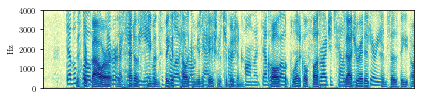

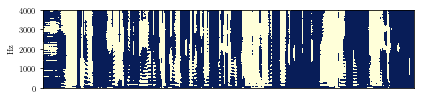

In [ ]:
truncated_mask_spec = mask_spec_1.transpose(1,0)[:,:mix_spec[1].shape[0]]

#ax1.set_title("(a) Short-time spectrum of a mixture")
#ax2.set_title("(b) Mask for a single speaker")
#ax3.set_title("(c) Mask of (b) applied to the mixture")

fig, ax1 = plt.subplots(figsize=(6,1.5))
ax1.tick_params(axis="x", labelsize=FONT_SIZE)
ax1.tick_params(axis="y", labelsize=FONT_SIZE)
ax1.set_ylabel("Hz", fontsize = FONT_SIZE)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(mix_spec)), sr=8000, hop_length=64, y_axis='linear', cmap='YlGnBu', ax=ax1) # gray_r
plt.tight_layout()
fig.savefig("../../workspace/figures/masking_demonstration-1.pdf", bbox_inches='tight',pad_inches = 0, dpi=1200)
plt.show()

fig, ax1 = plt.subplots(figsize=(6,1.5))
ax1.tick_params(axis="x", labelsize=FONT_SIZE)
ax1.tick_params(axis="y", labelsize=FONT_SIZE)
ax1.set_ylabel("Hz", fontsize = FONT_SIZE)
librosa.display.specshow(truncated_mask_spec, sr=8000, hop_length=64, y_axis='linear', cmap='YlGnBu', ax=ax1) # gray_r
plt.tight_layout()
fig.savefig("../../workspace/figures/masking_demonstration-2.pdf", bbox_inches='tight',pad_inches = 0, dpi=1200)
plt.show()

fig, ax1 = plt.subplots(figsize=(6,1.85))
ax1.tick_params(axis="x", labelsize=FONT_SIZE)
ax1.tick_params(axis="y", labelsize=FONT_SIZE)
ax1.set_ylabel("", fontsize = FONT_SIZE)
ax1.set_xlabel("", fontsize = FONT_SIZE)
speech1_spec = truncated_mask_spec * mix_spec
librosa.display.specshow(librosa.amplitude_to_db(np.abs(speech1_spec)), sr=8000, hop_length=64, y_axis='linear', x_axis='s', cmap='YlGnBu', ax=ax1) 
plt.tight_layout()
fig.savefig("../../workspace/figures/masking_demonstration-3.pdf", bbox_inches='tight',pad_inches = 0, dpi=1200)
plt.show()

## Activation functions

In [97]:
def actv_plot(func, yaxis=(-1.4, 1.4), xaxis=None):
    x = np.arange(-5, 5, 0.01)
    plt.figure(figsize=(1.5, 1.0))
    plt.ylim(yaxis)
    if xaxis:
        plt.xlim(xaxis)
    plt.locator_params(nbins=5,integer=True)
    plt.xticks(fontsize = FONT_SIZE)
    plt.yticks(fontsize = FONT_SIZE)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom=True, right='off', left=False, labelleft=True)
    plt.axhline(c='black')
    plt.axvline(c='black')
    #plt.grid(alpha=0.4, ls='-.')
    plt.box(on=None)
    plt.plot(x, func(x), c='r')

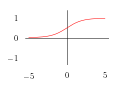

In [98]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


actv_plot(sigmoid)
plt.savefig(os.path.join(path, "sigmoid.pdf"), bbox_inches = 'tight',pad_inches = 0)

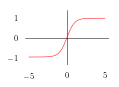

In [99]:
def tanh(x):
    return 2 / (1 + np.exp(-2 * x)) -1

actv_plot(tanh)
plt.savefig(os.path.join(path, "tanh.pdf"), bbox_inches = 'tight',pad_inches = 0)

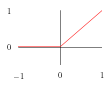

In [100]:
relu = np.vectorize(lambda x: x if x > 0 else 0, otypes=[np.float])
actv_plot(relu, yaxis=(-0.5, 1), xaxis=(-1, 1))
plt.savefig(os.path.join(path, "relu.pdf"), bbox_inches = 'tight',pad_inches = 0)

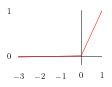

In [101]:
leaky_relu = np.vectorize(lambda x: x if x > 0 else 0.01 * x, otypes=[np.float])
actv_plot(leaky_relu, yaxis=(-0.2, 1), xaxis=(-3, 1))
plt.savefig(os.path.join(path, "leaky_relu.pdf"), bbox_inches = 'tight',pad_inches = 0)

## Cluster visualization

In [104]:
mix_path = "../../workspace/eval/wsj0-train-mix.wav"
model_dir = "../../workspace/exp-models/1a/seeds"
config = Config()
config.load_json("../../sync/experiments/1a/config.json")

inference = Inference(config)
mix, _ = librosa.load(mix_path, sr=8000)
mix_spec = librosa.core.stft(mix, n_fft=256, hop_length=64, window=np.hanning, center=False)

session, embedding_model, in_data, in_data, dropout_ff, dropout_rc = inference.prepare_session(model_dir)
embeddings, N_samples = inference.estimate_embeddings(session, mix, embedding_model, in_data, dropout_ff, dropout_rc)
session.close()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Embeddings: 31
Calculating cluster visualisation...


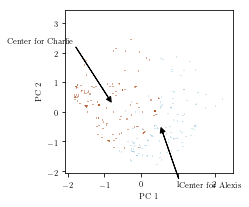

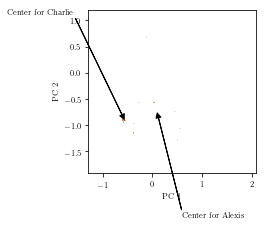

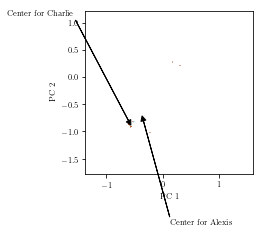

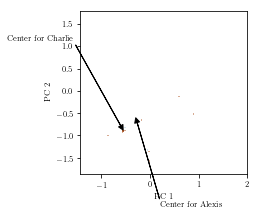

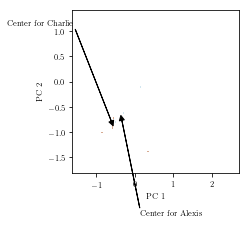

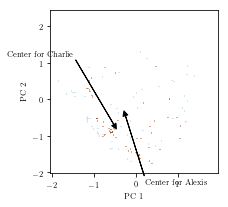

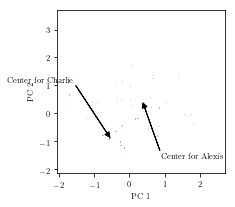

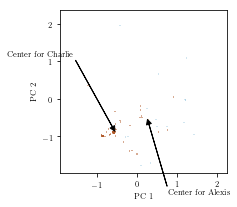

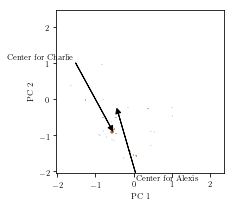

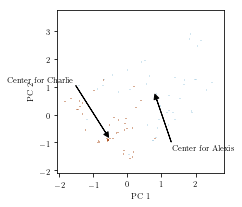

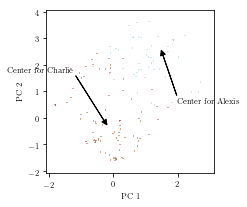

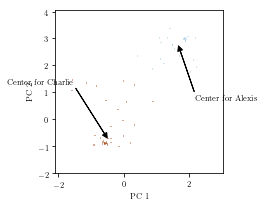

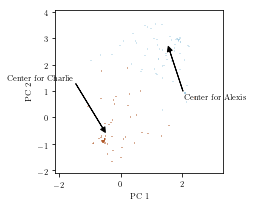

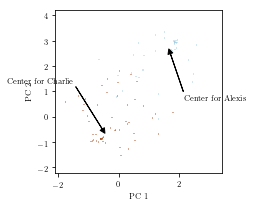

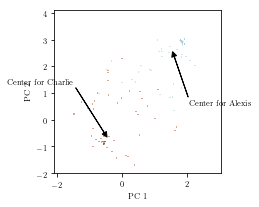

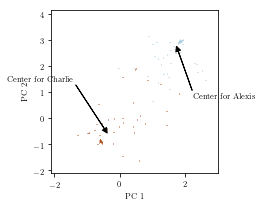

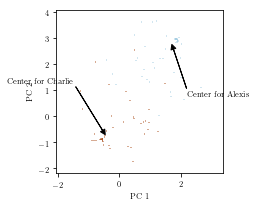

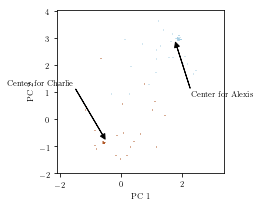

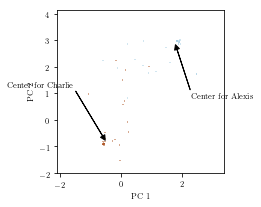

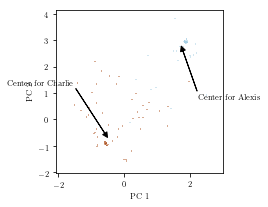

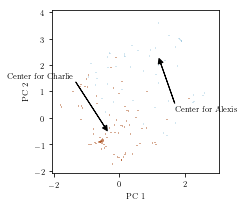

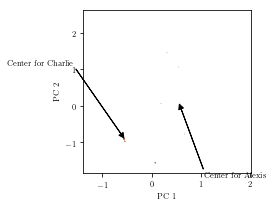

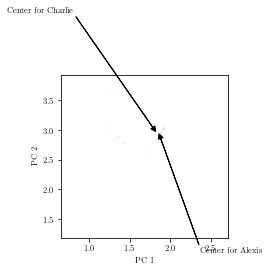

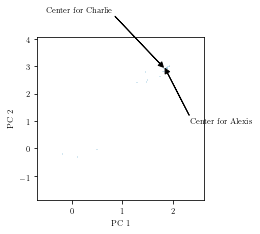

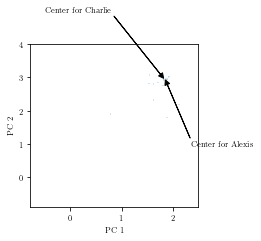

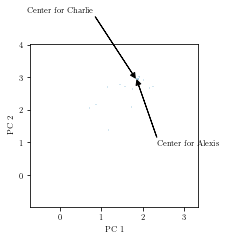

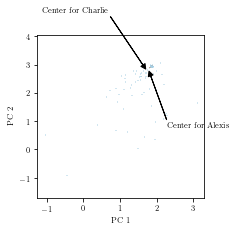

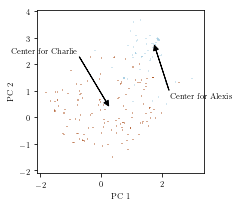

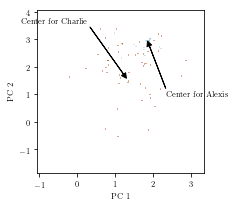

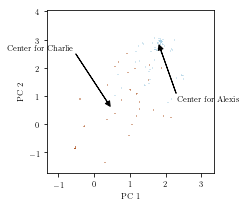

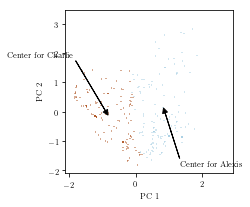

In [179]:
#fig, axes = plt.subplots(len(embeddings) // 3 + 1, 3, figsize=(20,10), squeeze=False, subplot_kw={'projection': '3d'})
#axes = np.array(axes).flatten()

print("Embeddings: %d" % len(embeddings))
print("Calculating cluster visualisation...")

windows_per_sample = 100
effective_ft_points = 129
init = 'k-means++'
n_init = 10

pca = PCA(n_components=2,random_state=0,whiten=True)

for i, (embedding, data_batch) in enumerate(embeddings):
    embedding = embedding.reshape(windows_per_sample * effective_ft_points, 40)
    pca.fit(embedding)

for i, (embedding, data_batch) in enumerate(embeddings):
    #fig = plt.figure(1, figsize=(8, 6))
    #ax = Axes3D(fig, elev=-150, azim=110)
    #ax.set_xlabel('PC 1')
    #ax.set_ylabel('PC 2')
    #ax.set_zlabel('PC 3')
    
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.set_xlabel('PC 1',fontsize = FONT_SIZE)
    ax.set_ylabel('PC 2',fontsize = FONT_SIZE)
    plt.xticks(fontsize = FONT_SIZE)
    plt.yticks(fontsize = FONT_SIZE)
    #ax.set_xlim(-1.1, 1.6)
    #ax.set_ylim(-3, 3.4)
    
    in_data_np, in_phase_np, VAD_data_np = data_batch
    embedding = embedding.reshape(windows_per_sample * effective_ft_points, 40)
    #embedding = [embedding[i, j, :]
    #                for i, j in itertools.product(range(windows_per_sample), range(effective_ft_points))
    #                if VAD_data_np[0, i, j] == 1
    #            ]
    
    kmean = KMeans(algorithm='full', random_state=0, n_clusters=2, n_init=n_init, init=init)
    kmean.fit(embedding)
    init = kmean.cluster_centers_
    n_init = 1
    
    labels = kmean.labels_
    labels = np.append(labels, [0.5, 0.5], axis=0)
    embedding = np.append(embedding, kmean.cluster_centers_, axis=0)
    
    low_dimensional_data = pca.transform(embedding)
    #low_dimensional_data = TSNE(n_components=2).fit_transform(embedding)
    ax.scatter(low_dimensional_data[:, 0], low_dimensional_data[:, 1],
                c=labels, cmap=plt.cm.Paired, s=0.0001, marker=',')
    ax.annotate('Center for Charlie',
            fontsize = FONT_SIZE,
            xy=low_dimensional_data[-1],
            xytext=low_dimensional_data[-1] + (-1, 2),
            arrowprops=dict(facecolor='black', width=0.1, headwidth=5, headlength=5),
            horizontalalignment='right'
    )
    
    ax.annotate('Center for Alexis',
            fontsize = FONT_SIZE,
            xy=low_dimensional_data[-2],
            xytext=low_dimensional_data[-2] + (0.5, -2),
            arrowprops=dict(facecolor='black', width=0.1, headwidth=5, headlength=5),
            horizontalalignment='left'
    )

    plt.savefig(os.path.join(path, "pca" + str(i) + ".pdf"), bbox_inches = 'tight',pad_inches = 0)
    plt.show()
    

## Elbow

In [163]:
def calc_embeddings(mix_path):
    model_dir = "../../workspace/exp-models/1a/seeds"
    config = Config()
    config.load_json("../../sync/experiments/1a/config.json")

    inference = Inference(config)
    mix, _ = librosa.load(mix_path, sr=8000)
    mix_spec = librosa.core.stft(mix, n_fft=256, hop_length=64, window=np.hanning, center=False)

    session, embedding_model, in_data, in_data, dropout_ff, dropout_rc = inference.prepare_session(model_dir)
    embeddings, N_samples = inference.estimate_embeddings(session, mix, embedding_model, in_data, dropout_ff, dropout_rc)
    session.close()
    return embeddings

In [164]:
def cluster(embeddings):
    print("Embeddings: %d" % len(embeddings))
    print("Calculating cluster visualisation...")

    windows_per_sample = 100
    effective_ft_points = 129
    init = 'k-means++'
    n_init = 10
    k_range = range(1, 5)

    scale = 1
    inits = [['k-means++' for i in k_range] for i in range(0, len(embeddings)*scale)]
    scores = [[0 for i in k_range] for i in range(0, len(embeddings)*scale)]
    
    counter = 0

    def vodoo(X):
        return np.matmul(np.matmul(X, np.linalg.inv(np.matmul(X.transpose(), X))), X.transpose())

    for i, (whole_embedding, data_batch) in enumerate(embeddings):
        in_data_np, in_phase_np, VAD_data_np = data_batch
        whole_embedding = whole_embedding.reshape(scale, windows_per_sample // scale * effective_ft_points, 40)
        
        for u, embedding in enumerate(whole_embedding):
            kmeans = [KMeans(n_clusters=j, 
                             algorithm='full', 
                             random_state=0) for j in k_range]

            scores[i*(scale)+u] = [kmean.fit(embedding).score(embedding) for kmean in kmeans]
            inits[i*(scale)+u] = np.array([kmean.cluster_centers_ for kmean in kmeans])
            n_init = 1


            k = 2
            eg = kmeans[k-1].predict(embedding)

            mask = np.zeros((k, windows_per_sample // scale * effective_ft_points))
            #for i in range(k):
            #    mask[i, eg == i] = 1

            #Z = mask.reshape(k, -1).transpose() # -1, k
            #Y = Z

            #error = np.linalg.norm(vodoo(Y) - vodoo(Z), "fro")
            #print(error)

            #plt.plot(k_range, score, marker="D", label="score")
            #plt.savefig(os.path.join(path, "pca" + str(i) + ".pdf"), bbox_inches = 'tight',pad_inches = 0)
            #plt.show()
    return inits, scores

In [165]:
# k=1
def plot_distance_to_zero_k1(centers):
    k2_centers = np.empty((len(centers), 1, 40))
    for i in range(0, len(centers)):
        k2_centers[i] = np.array(centers)[i][0]

    k2_centers = np.transpose(k2_centers, (1, 0, 2))
    distances = np.sum((k2_centers[0])**2, axis=1)
    return plt.plot(range(0, len(centers)), distances, label="$k=1$", color='black')

In [166]:
# k=2
def plot_distance_k2(centers):
    k2_centers = np.empty((len(centers), 2, 40))
    for i in range(0, len(centers)):
        k2_centers[i] = np.array(centers)[i][1]

    k2_centers = np.transpose(k2_centers, (1, 0, 2))
    distances = np.sum((k2_centers[0] - k2_centers[1])**2, axis=1)
    return plt.plot(range(0, len(centers)), distances, label="$k=2$", color='red')

In [111]:
# k=3 avg
def plot_distance_avg_k3(centers):
    k2_centers = np.empty((len(centers), 3, 40))
    for i in range(0, len(centers)):
        k2_centers[i] = np.array(centers)[i][2]

    k2_centers = np.transpose(k2_centers, (1, 0, 2))
    distances = np.sum(
        ((k2_centers[0] - k2_centers[1])**2 + 
        (k2_centers[0] - k2_centers[2])**2 +
        (k2_centers[1] - k2_centers[2])**2)/3, 
        axis=1)
    return plt.plot(range(0, len(centers)), distances, label="$k=3$ (average)")

In [112]:
# k=3 min
def plot_distance_min_k3(centers):
    k2_centers = np.empty((len(centers), 3, 40))
    for i in range(0, len(centers)):
        k2_centers[i] = np.array(centers)[i][2]

    k2_centers = np.transpose(k2_centers, (1, 0, 2))

    a = np.array([(k2_centers[0] - k2_centers[1])**2,
        (k2_centers[0] - k2_centers[2])**2,
        (k2_centers[1] - k2_centers[2])**2])
    a = a.transpose(1, 0, 2)
    a = np.sum(a, axis=2)
    a = np.amin(a, axis=1)

    return plt.plot(range(0, len(centers)), a, label="$k=3$ (minimum)")

In [177]:
def plot_scores(scores):
    k1_scores = np.array(scores)[:,0]
    k2_scores = np.array(scores)[:,1]
    #k3_scores = np.array(scores)[:,2]
    #k4_scores = np.array(scores)[:,3]

    k1, = plt.plot(range(0, len(scores)), -k1_scores, label="$k=1$", color='black')
    k2, = plt.plot(range(0, len(scores)), -k2_scores, label="$k=2$", color='red')
    #k3, = plt.plot(range(0, len(scores)), -k3_scores, label="$k=3$", color='blue')
    #k4, = plt.plot(range(0, len(scores)), -k4_scores, label="$k=4$", color='orange')
    
    plt.legend(handles=[k1, k2], fontsize=6, loc='upper left')


    #fig = plt.figure(figsize=(3,3))
    #ax = fig.add_subplot(111, projection='3d')

    #ver_time = -1 * np.array([k1_scores, k2_scores, k3_scores])

    # = np.array(range(1, 4))
    # = np.array(range(0, 31))

    #, y = np.meshgrid(x, y)

    #ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 2, 1, 1]))

    #ax.plot_surface(d, y, over_time.transpose(), rstride=1, cstride=1, linewidth=0, antialiased=True)

    #ax.plot_wireframe(d, y, over_time.transpose(), rstride=10, cstride=10)

    #plt.show()

In [179]:
embeddings = calc_embeddings("../../workspace/eval/elbow/output.wav")
embeddings2 = calc_embeddings("../../workspace/eval/elbow2/output.wav")

In [180]:
centers, scores = cluster(embeddings)
centers2, scores2 = cluster(embeddings2)

Embeddings: 41
Calculating cluster visualisation...
Embeddings: 27
Calculating cluster visualisation...


In [186]:
def fig_centers(centers, name):
    fig, ax1 = plt.subplots(figsize=(3,1.4))

    k1, = plot_distance_to_zero_k1(centers)
    k2, = plot_distance_k2(centers)
    #k31, = plot_distance_avg_k3(centers)
    #k32, = plot_distance_min_k3(centers)

    plt.legend(handles=[k1, k2], fontsize=6, loc='lower right')

    #ax1.set_xlim(0, len(wss))
    ax1.set_ylim(0, 1.5)
    ax1.set_ylabel("Distance", fontsize = FONT_SIZE)
    ax1.set_xlabel("Frame", fontsize = FONT_SIZE)
    ax1.tick_params(axis="x", labelsize=FONT_SIZE)
    ax1.tick_params(axis="y", labelsize=FONT_SIZE)

    fig.tight_layout()

    fig.savefig(os.path.join(path, "centers_" + name + ".pdf"), bbox_inches = 'tight',pad_inches = 0)
    fig.show()

In [191]:
def fig_scores(scores, name):
    fig, ax1 = plt.subplots(figsize=(3,1.4))

    plot_scores(scores)

    #ax1.set_xlim(0, len(wss))
    ax1.set_ylabel("WCE", fontsize = FONT_SIZE)
    ax1.set_xlabel("Frame", fontsize = FONT_SIZE)
    ax1.tick_params(axis="x", labelsize=FONT_SIZE)
    ax1.tick_params(axis="y", labelsize=FONT_SIZE)

    fig.tight_layout()

    fig.savefig(os.path.join(path, "scores_" + name + ".pdf"), bbox_inches = 'tight',pad_inches = 0)
    fig.show()

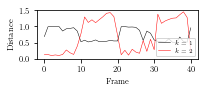

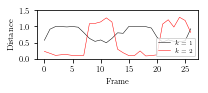

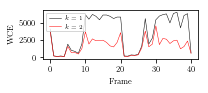

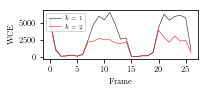

In [192]:
fig_centers(centers, "1")
fig_centers(centers2, "2")
fig_scores(scores, "1")
fig_scores(scores2, "2")

# Loss plots

0
1a
1c
1d
1e
1f
1g
1h
1i
2a
2b
2d
3a
3b
3c
3d
4a
4a
4b
4c


/fast/ammannma/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


5a
5b
5c


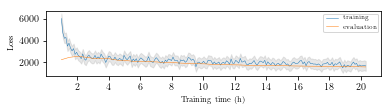

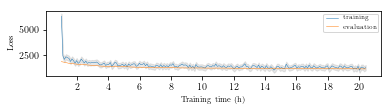

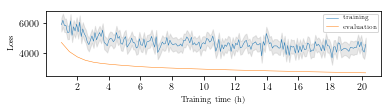

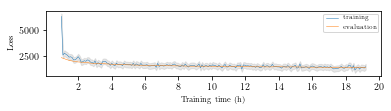

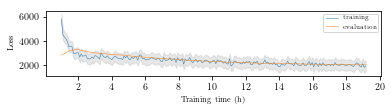

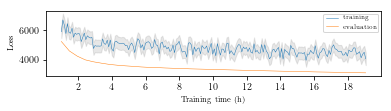

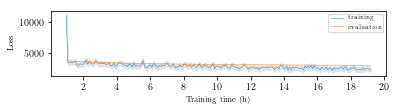

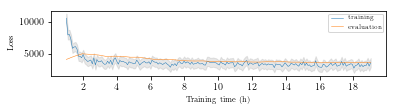

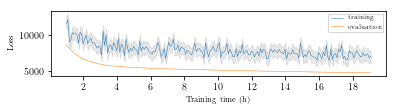

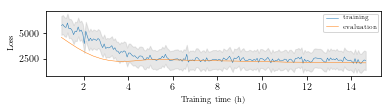

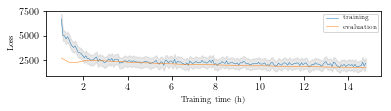

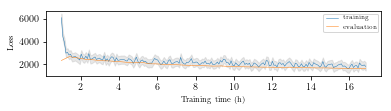

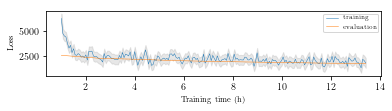

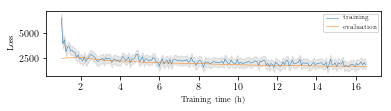

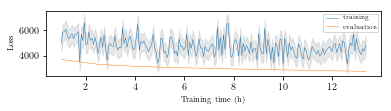

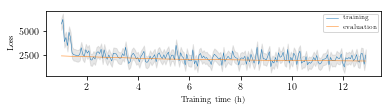

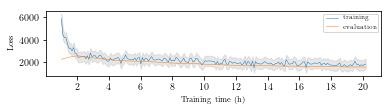

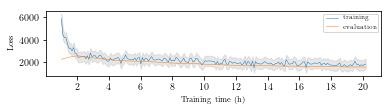

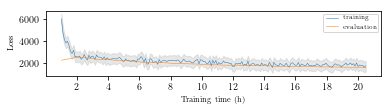

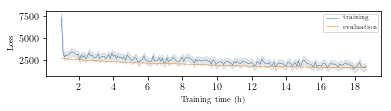

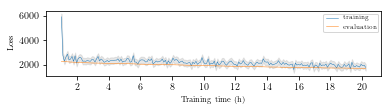

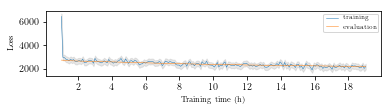

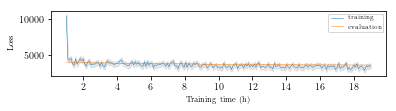

In [41]:
import matplotlib.dates as mdates
import glob
import datetime

model_dir = "../../workspace/eval/exp-models/"
loss_plots = [
    ["0", model_dir + "0"],
    ["1a", model_dir + "1a"],
    ["1c", model_dir + "1c"],
    ["1d", model_dir + "1d"],
    ["1e", model_dir + "1e"],
    ["1f", model_dir + "1f"],
    ["1g", model_dir + "1g"],
    ["1h", model_dir + "1h"],
    ["1i", model_dir + "1i"],
    
    ["2a", model_dir + "2a"],
    ["2b", model_dir + "2b"],
    ["2d", model_dir + "2d"],
    
    ["3a", model_dir + "3a"],
    ["3b", model_dir + "3b"],
    ["3c", model_dir + "3c"],
    ["3d", model_dir + "3d"],
    
    ["4a", model_dir + "4a"],
    ["4a", model_dir + "4a"],
    ["4b", model_dir + "4b"],
    ["4c", model_dir + "4c"],
    
    ["5a", model_dir + "5a"],
    ["5b", model_dir + "5b"],
    ["5c", model_dir + "5c"],
]

def plot_train_val(name, train_loss, val_loss, duration, ax):
    # Make the plot easier to read by thinning it
    n = len(train_loss)
    
    train_thinning = int(n/200)
    
    if train_thinning == 0:
        train_thinning = 1
        
    x_train = np.arange(len(train_loss))[0::train_thinning]
    x_val = np.arange(len(val_loss))
    
    if len(x_val) > 0:
        x_val = np.interp(x_val, (0, x_val.max()), (0, len(train_loss)))
    
    # Use time
    x_val = np.interp(x_val, (0, x_val.max()), (0, duration))
    x_train = np.interp(x_train, (0, x_train.max()), (0, duration))

    x_val = [datetime.datetime.fromtimestamp(unix) for unix in x_val]
    x_train = [datetime.datetime.fromtimestamp(unix) for unix in x_train]

    ax.set_yscale('linear')
    myFmt = mdates.DateFormatter('%-H')
    ax.xaxis.set_major_formatter(myFmt)
    
    train_loss /= 10
    val_loss /= 10
    full_train_loss = train_loss
    train_loss = train_loss[0::train_thinning]

    ax.fill_between(x_train, train_loss - full_train_loss.std(), train_loss + full_train_loss.std(), color='#888888', alpha=0.2)
    l1, = ax.plot(x_train, train_loss, label="training")
    l2, = ax.plot(x_val, val_loss, label="evaluation")
    plt.legend(handles=[l1, l2], fontsize=6, loc='upper right')
    
    ax.set_ylabel("Loss", fontsize = FONT_SIZE)
    ax.set_xlabel("Training time (h)", fontsize = FONT_SIZE)


for i, (name, summary_path) in enumerate(loss_plots):
    fig, ax = plt.subplots(figsize=(6,1.2))
    
    print(name)
    events = list(tf.train.summary_iterator(glob.glob(summary_path + "/summary/events.out.tfevents.*")[0]))
    duration = int(events[-1].wall_time) - int(events[0].wall_time)
    
    plot_train_val(name, np.load(summary_path + "/summary/train_loss.npy"), np.load(summary_path + "/summary/val_loss.npy"), duration, ax)
    fig.savefig(os.path.join(path, "loss_plot_" + name + ".pdf"), bbox_inches = 'tight',pad_inches = 0)
    fig.show()